In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib as mpl

# 解决matplotlib中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['font.family'] = 'SimHei'  # 设置全局字体为黑体

# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 查看数据集基本信息
print("数据集特征:", housing.feature_names)
print("数据集形状:", X.shape)
print("目标变量形状:", y.shape)

# 数据集拆分为训练集、验证集和测试集
# 首先将数据分为训练集(80%)和测试集(20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 然后将训练集部分再次拆分为训练集(75%)和验证集(25%)，相当于整体数据的60%和20%
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("\n训练集形状:", X_train.shape)  # 60%的数据
print("验证集形状:", X_val.shape)    # 20%的数据
print("测试集形状:", X_test.shape)   # 20%的数据

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 创建自定义数据集类，继承自PyTorch的Dataset类
class CaliforniaHousingDataset(Dataset):
    def __init__(self, features, targets):
        """
        初始化数据集
        
        参数:
            features: 房屋特征数据
            targets: 房价目标值
        """
        # 将NumPy数组转换为PyTorch张量
        self.features = torch.FloatTensor(features)
        # 确保目标值是二维张量，形状为[样本数, 1]
        self.targets = torch.FloatTensor(targets).reshape(-1, 1)
    
    def __len__(self):
        """
        返回数据集中样本的数量
        """
        return len(self.features)
    
    def __getitem__(self, idx):
        """
        根据索引返回对应的特征和标签
        
        参数:
            idx: 样本索引
            
        返回:
            特征张量和对应的目标值张量
        """
        return self.features[idx], self.targets[idx]

# 实例化训练集、验证集和测试集
train_dataset = CaliforniaHousingDataset(X_train_scaled, y_train)
val_dataset = CaliforniaHousingDataset(scaler.transform(X_val), y_val)
test_dataset = CaliforniaHousingDataset(X_test_scaled, y_test)


数据集特征: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
数据集形状: (20640, 8)
目标变量形状: (20640,)

训练集形状: (12384, 8)
验证集形状: (4128, 8)
测试集形状: (4128, 8)


In [5]:
# 导入必要的PyTorch模块
import torch.nn as nn
from torch.utils.data import DataLoader

# 创建数据加载器，用于批量训练
batch_size = 64  # 每批处理的样本数量
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 训练集加载器，打乱数据
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # 验证集加载器
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # 测试集加载器

# 定义神经网络模型
class HousingModel(nn.Module):
    def __init__(self, input_dim):
        """
        初始化房价预测模型
        
        参数:
            input_dim: 输入特征的维度
        """
        super(HousingModel, self).__init__()
        # 定义神经网络层
        self.layer1 = nn.Linear(input_dim, 64)  # 第一层全连接层，输出64个神经元
        self.layer2 = nn.Linear(64, 32)  # 第二层全连接层，输出32个神经元
        self.layer3 = nn.Linear(32, 1)  # 输出层，输出房价预测值
        self.relu = nn.ReLU()  # ReLU激活函数
        self.dropout = nn.Dropout(0.2)  # Dropout层，防止过拟合，丢弃20%的神经元
        
    def forward(self, x):
        """
        前向传播过程
        
        参数:
            x: 输入特征张量
            
        返回:
            模型预测的房价值
        """
        x = self.relu(self.layer1(x))  # 第一层全连接后接ReLU激活
        x = self.dropout(x)  # 应用dropout
        x = self.relu(self.layer2(x))  # 第二层全连接后接ReLU激活
        x = self.layer3(x)  # 输出层，无需激活函数
        return x

# 初始化模型、损失函数和优化器
input_dim = X_train_scaled.shape[1]  # 获取特征维度
model = HousingModel(input_dim)  # 创建模型实例
criterion = nn.MSELoss()  # 使用均方误差损失函数，适合回归问题
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器，学习率为0.001
# 打印模型结构
print("模型结构:")
print(model)

# 打印模型参数数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型总参数数量: {total_params}")
print(f"可训练参数数量: {trainable_params}")

# 可视化网络结构
print("\n模型结构详情:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")



模型结构:
HousingModel(
  (layer1): Linear(in_features=8, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
模型总参数数量: 2689
可训练参数数量: 2689

模型结构详情:
layer1.weight: torch.Size([64, 8])
layer1.bias: torch.Size([64])
layer2.weight: torch.Size([32, 64])
layer2.bias: torch.Size([32])
layer3.weight: torch.Size([1, 32])
layer3.bias: torch.Size([1])


开始训练模型...


训练进度:  11%|█         | 11/100 [00:01<00:12,  7.06it/s]

轮数 [10/100], 损失: 0.2640


训练进度:  21%|██        | 21/100 [00:03<00:11,  6.94it/s]

轮数 [20/100], 损失: 0.2635


训练进度:  31%|███       | 31/100 [00:04<00:09,  7.16it/s]

轮数 [30/100], 损失: 0.2576


训练进度:  41%|████      | 41/100 [00:05<00:08,  7.22it/s]

轮数 [40/100], 损失: 0.2536


训练进度:  51%|█████     | 51/100 [00:07<00:06,  7.10it/s]

轮数 [50/100], 损失: 0.2556


训练进度:  61%|██████    | 61/100 [00:08<00:05,  7.15it/s]

轮数 [60/100], 损失: 0.2532


训练进度:  71%|███████   | 71/100 [00:10<00:04,  7.11it/s]

轮数 [70/100], 损失: 0.2544


训练进度:  81%|████████  | 81/100 [00:11<00:02,  7.19it/s]

轮数 [80/100], 损失: 0.2546


训练进度:  91%|█████████ | 91/100 [00:12<00:01,  7.24it/s]

轮数 [90/100], 损失: 0.2513


训练进度: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]

轮数 [100/100], 损失: 0.2498


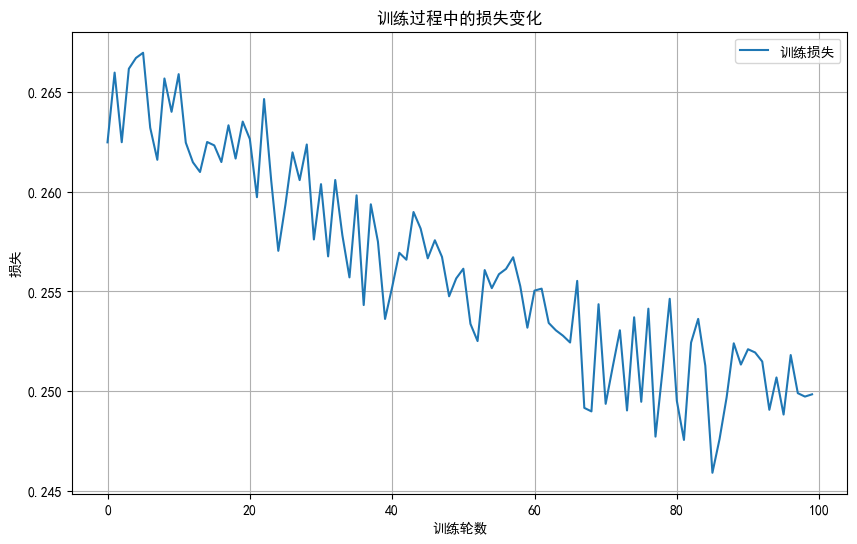

In [8]:
# 导入tqdm库用于显示训练进度条
from tqdm import tqdm

# 定义训练函数
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    """
    训练模型函数
    
    参数:
        model: 神经网络模型
        train_loader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
    
    返回:
        训练过程中的损失列表
    """
    # 记录训练损失
    train_losses = []
    
    # 将模型设置为训练模式
    model.train()
    
    # 使用tqdm创建训练轮数的进度条
    for epoch in tqdm(range(num_epochs), desc="训练进度"):
        epoch_loss = 0.0
        batch_count = 0
        
        # 遍历训练数据批次
        for inputs, targets in train_loader:
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, targets)
            
            # 反向传播
            loss.backward()
            
            # 更新参数
            optimizer.step()
            
            # 累加批次损失
            epoch_loss += loss.item()
            batch_count += 1
        
        # 计算平均损失
        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)
        
        # 每10轮打印一次训练信息
        if (epoch + 1) % 10 == 0:
            print(f'轮数 [{epoch+1}/{num_epochs}], 损失: {avg_loss:.4f}')
    
    return train_losses

# 训练模型
print("开始训练模型...")
num_epochs = 100
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

# 可视化训练损失
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='训练损失')
plt.title('训练过程中的损失变化')
plt.xlabel('训练轮数')
plt.ylabel('损失')
plt.legend()
plt.grid(True)
plt.show()



In [9]:

# 定义评估函数
def evaluate_model(model, data_loader):
    model.eval()  # 设置为评估模式
    total_loss = 0
    total_samples = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():  # 不计算梯度
        for inputs, targets in data_loader:
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, targets)
            
            # 累加损失和样本数
            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
    
    # 计算平均损失（MSE）
    avg_loss = total_loss / total_samples
    return avg_loss

# 评估模型
print("模型评估结果:")
train_mse = evaluate_model(model, train_loader)
val_mse = evaluate_model(model, val_loader)
test_mse = evaluate_model(model, test_loader)

print(f"训练集均方误差 (MSE): {train_mse:.4f}")
print(f"验证集均方误差 (MSE): {val_mse:.4f}")
print(f"测试集均方误差 (MSE): {test_mse:.4f}")

# 计算RMSE（均方根误差）
import numpy as np
print(f"训练集均方根误差 (RMSE): {np.sqrt(train_mse):.4f}")
print(f"验证集均方根误差 (RMSE): {np.sqrt(val_mse):.4f}")
print(f"测试集均方根误差 (RMSE): {np.sqrt(test_mse):.4f}")


模型评估结果:
训练集均方误差 (MSE): 0.2341
验证集均方误差 (MSE): 0.2720
测试集均方误差 (MSE): 0.2756
训练集均方根误差 (RMSE): 0.4838
验证集均方根误差 (RMSE): 0.5215
测试集均方根误差 (RMSE): 0.5250
